Features: 3000/12441IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Features: 10316/12441IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Best Parameters: {'C': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9864960909737029
F1 Score: 0.9573033707865168
Precision: 0.9770642201834863
Recall: 0.9383259911894273

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1180
           1       0.98      0.94      0.96       227

    accuracy                           0.99      1407
   macro avg       0.98      0.97      0.97      1407
weighted avg       0.99      0.99      0.99      1407



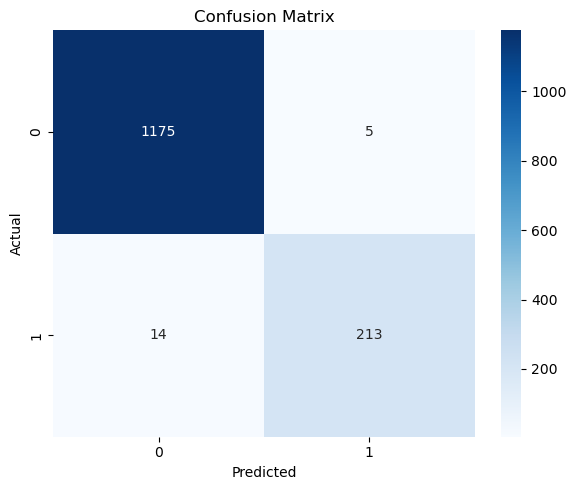

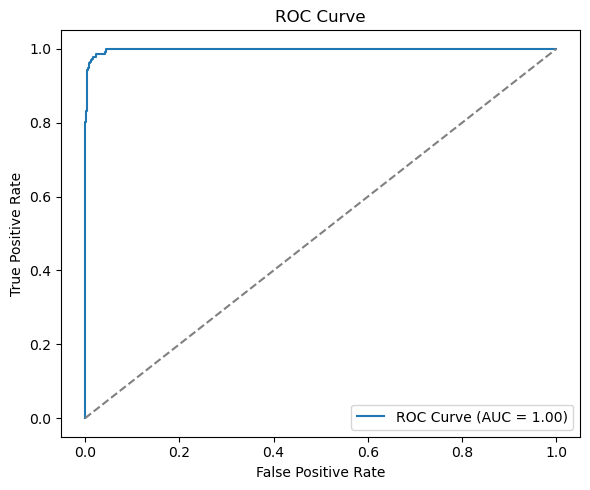


Model saved to best_svm_model.joblib
Selected features saved to best_features_svm.csv


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.metrics import roc_curve, auc
from joblib import dump
import ml_helpers as hlp

def select_features(X_train, y_train, min_features=6, max_features=10):
    """Perform exhaustive feature selection using SVC."""
    svc = SVC(kernel='rbf', random_state=42)
    efs = ExhaustiveFeatureSelector(
        svc,
        min_features=min_features,
        max_features=max_features,
        scoring='f1',
        cv=3,
        n_jobs=-1
    )
    efs.fit(X_train.values, y_train.values)
    selected_indices = list(efs.best_idx_)
    selected_features = X_train.columns[selected_indices].tolist()
    return selected_features

def train_model(X_train, y_train):
    """Perform grid search to find best SVC model."""
    param_grid = {
    'C': [0.1, 1, 10, 50],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3],
    'gamma': ['scale', 'auto']
    }

    grid = GridSearchCV(SVC(random_state=42), param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

def save_model_and_features(model, features, model_path="best_svm_model.joblib", features_path="best_features_svm.csv"):
    """Save model and selected features to disk."""
    dump(model, model_path)
    pd.Series(features).to_csv(features_path, index=False, header=["Selected_Feature"])
    print(f"\nModel saved to {model_path}")
    print(f"Selected features saved to {features_path}")

def plot_roc(model,X_test,y_test):
    y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    hlp.plot_roc_curve(fpr, tpr)

if __name__ == "__main__":
    # dataset path
    filepath = "C:\\Users\\Jinane Rachid\\Desktop\\cleaned_nasa_data1.csv"
    #Load features (X) and target (y) from CSV
    X, y = hlp.load_data(filepath)
    # Split into training and test sets
    X_train, X_test, y_train, y_test = hlp.split_data(X, y)

    # Perform exhaustive feature selection on the training set
    best_features = select_features(X_train, y_train)
    #print("Best features:", best_features)

    # Subset training and test data to the selected features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Run grid search to train the best SVC on selected features
    best_model, best_params = train_model(X_train_best, y_train)
    print("Best Parameters:", best_params)

    # Evaluate the final model on the test set
    hlp.evaluate_model_basic(best_model, X_test_best, y_test)
    plot_roc(best_model, X_test_best, y_test)
    # Save the trained model and the list of selected features to disk
    save_model_and_features(best_model, best_features)

